In [30]:
#!/usr/bin/env python

import torch
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib notebook

In [34]:
#Data generation
N=10**3
train_input,train_target,train_classes,test_input,test_target,test_classes=prologue.generate_pair_sets(N)
train_target=train_target.long()#.float for MSELoss, .long for CrossEntropy
train_input=train_input.float()

In [32]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target, mini_batch_size, crit=nn.MSELoss, eta = 1e-3, nb_epochs = 1000,print_=False):
    criterion = crit()
    optimizer = optim.SGD(model.parameters(), lr = eta)
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                loss = criterion(output[:,1], train_target.narrow(0, b, mini_batch_size))
            elif crit==nn.CrossEntropyLoss:
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            else:
                print("Loss not implemented")
            acc_loss = acc_loss + loss.item()
            model.zero_grad()
            loss.backward()
            optimizer.step()
            if False:
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad

        if(e%20==0 and print_):
            print(e, acc_loss)
            
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

def run_many_times(model,crit=nn.MSELoss,mini_batch_size=100,n=10,print_=False):
    average_error=0
    for i in range(n):
        m=model()
        train_model(m, train_input, train_target,mini_batch_size,crit=crit)
        nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
        average_error+=(100 * nb_test_errors) / test_input.size(0)
    print("Average error: "+str(average_error/n))

In [33]:
#Is it better to use groups or not?
#Takes about 2 hours to run
#about 22.5% error average without groups if we exclude outliers that get stuck and don't move
#about 21.5% error average with groups if we exclude outliers that get stuck and don't move
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(512, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.softmax(self.fc2(x), dim=1)
        #print(x)
        return x
    def last_hiddes(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 512)))
        return x

class NetGroups(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, groups=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(512, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.softmax(self.fc2(x), dim=1)
        #print(x)
        return x

print("Without groups:")
run_many_times(Net)

print("With groups:")
run_many_times(NetGroups)

Without groups:
test error Net 24.10% 241/1000
test error Net 23.00% 230/1000
test error Net 23.00% 230/1000
test error Net 22.40% 224/1000
test error Net 21.70% 217/1000
test error Net 22.10% 221/1000
test error Net 22.10% 221/1000
test error Net 21.70% 217/1000
test error Net 46.20% 462/1000
test error Net 21.90% 219/1000
Average error: 24.82
With groups:
test error Net 20.30% 203/1000
test error Net 20.60% 206/1000
test error Net 19.90% 199/1000
test error Net 20.80% 208/1000
test error Net 21.10% 211/1000
test error Net 20.30% 203/1000
test error Net 19.90% 199/1000
test error Net 21.40% 214/1000
test error Net 21.00% 210/1000
test error Net 20.50% 205/1000
Average error: 20.580000000000002


In [35]:
#Is it better with Cross entropy loss rather than MSE?
#Doesn't seem significantly better
print("With Cross Entropy Loss:")
run_many_times(NetGroups,crit=nn.CrossEntropyLoss)

With Cross Entropy Loss:
test error Net 24.50% 245/1000
test error Net 21.40% 214/1000
test error Net 22.10% 221/1000
test error Net 22.80% 228/1000
test error Net 20.40% 204/1000
test error Net 48.10% 481/1000
test error Net 48.20% 482/1000
test error Net 22.10% 221/1000
test error Net 22.30% 223/1000
test error Net 21.70% 217/1000
Average error: 27.360000000000003


In [9]:
#shuffling the dataset
permuted_index = torch.randperm(train_input.size()[0])
train_input_shuffled = train_input[permuted_index]
train_target_shuffled = train_target[permuted_index]
train_classes_shuffled = train_classes[permuted_index]


<IPython.core.display.Javascript object>


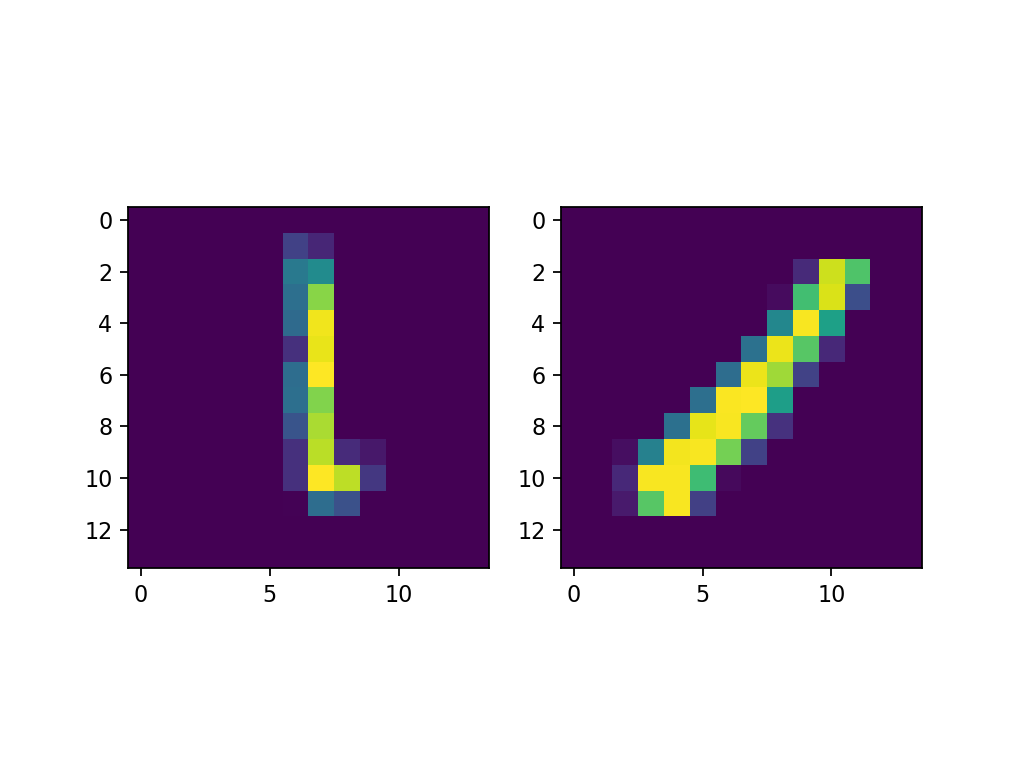

classes
tensor(1)
tensor(1)
target
tensor(1.)


In [10]:
#visual check
index = torch.randint(1000, (1,)).item()
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(train_input_shuffled[index][0])
fig.add_subplot(1, 2, 2)
plt.imshow(train_input_shuffled[index][1])
print('classes')
print(train_classes_shuffled[index][0])
print(train_classes_shuffled[index][1])
print('target')
print(train_target_shuffled[index])

In [11]:
#retraining net on shuffled data 
model2 = Net()
train_model(model2, train_input, train_target,mini_batch_size)
nb_test_errors = compute_nb_errors(model2, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

0 4.721060931682587
1 4.489994168281555
2 4.489993989467621
3 4.489993780851364
4 4.489993572235107
5 4.489993333816528
6 4.489993095397949
7 4.48999285697937
8 4.489992529153824
9 4.489992260932922
10 4.489991933107376
11 4.489991545677185
12 4.489991188049316
13 4.489990741014481
14 4.489990293979645
15 4.489989787340164
16 4.489989161491394
17 4.4899885058403015
18 4.489987820386887
19 4.48998698592186
20 4.489986062049866
21 4.489984959363937
22 4.489983707666397
23 4.489982217550278
24 4.489980459213257
25 4.4899782538414
26 4.489975541830063
27 4.489972144365311
28 4.489967614412308
29 4.489961415529251
30 4.489952445030212
31 4.489938467741013
32 4.489914268255234
33 4.489863753318787
34 4.4897163808345795
35 4.488993167877197
36 4.479214906692505
37 4.473145425319672
38 4.384496510028839
39 4.3129608035087585
40 4.0850368440151215
41 4.46708619594574
42 4.996514648199081
43 4.886212706565857
44 3.630129039287567
45 3.3587819635868073
46 3.166244998574257
47 3.2778791785240173
4

355 0.04695816042658407
356 0.046822590280498844
357 0.04676049745467026
358 0.04672469092474785
359 0.04670070496649714
360 0.04668355551257264
361 0.0466692773043178
362 0.046656919541419484
363 0.04664595622307388
364 0.04663479482405819
365 0.046624378926935606
366 0.046614203529316
367 0.04660452183452435
368 0.046594335639383644
369 0.04658532705070684
370 0.04657562706415774
371 0.046566472432459705
372 0.04655749371886486
373 0.046548726299079135
374 0.04654063691123156
375 0.046530900661309715
376 0.04671591395162977
377 0.04667961786617525
378 0.046574308835261036
379 0.046540208655642346
380 0.046519124938640743
381 0.046502384859195445
382 0.04649019310454605
383 0.0464799627152388
384 0.04647059368289774
385 0.046460754791041836
386 0.04645433617406525
387 0.04644497549452353
388 0.046438048710115254
389 0.04643105991999619
390 0.04642257413070183
391 0.04668264670181088
392 0.04661524727271171
393 0.046529083549103234
394 0.04648876772989752
395 0.046460110090265516
396 0

In [12]:
output = model(test_input.narrow(0, 0, mini_batch_size))
_, predicted_classes = output.max(1)

<IPython.core.display.Javascript object>


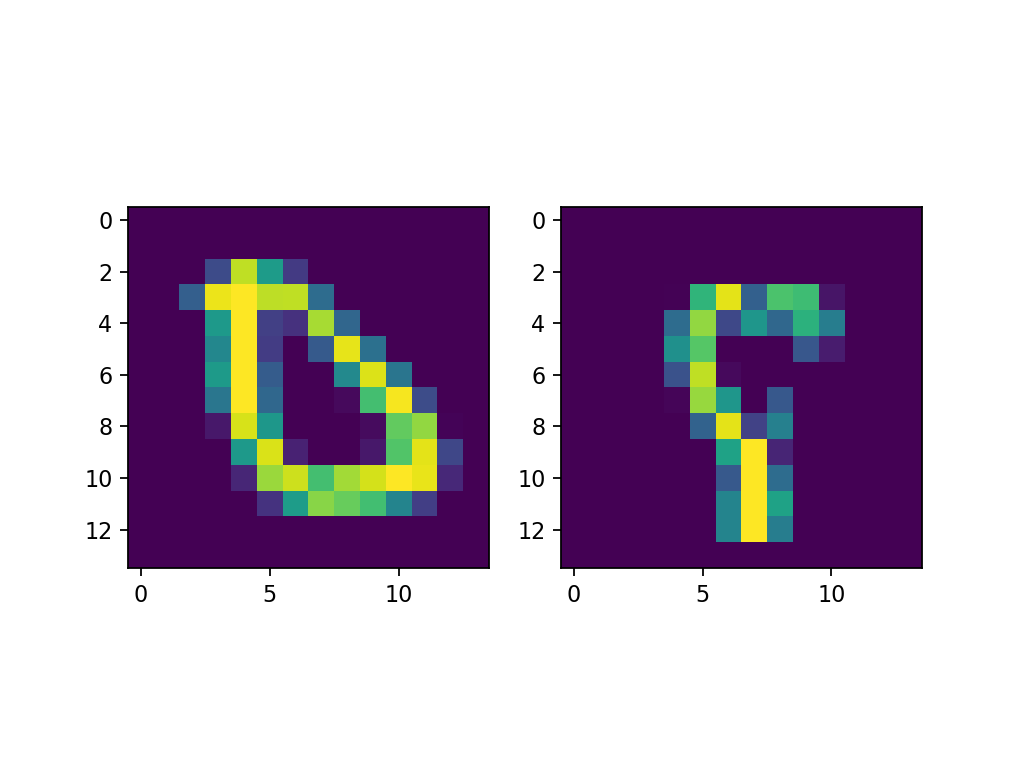

classes
tensor(0)
tensor(8)
target
tensor(1.)
last hidden layer tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, 38.9608,  0.0000,  0.0000,  0.0000,
          9.3183,  0.0000,  0.0000,  6.5973,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  3.6877,  0.0000,  1.1233]], grad_fn=<ReluBackward0>)


In [13]:
#looking at the last hidden layer
#visual check
index = torch.randint(1000, (1,)).item()
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(train_input_shuffled[index][0])
fig.add_subplot(1, 2, 2)
plt.imshow(train_input_shuffled[index][1])
print('classes')
print(train_classes_shuffled[index][0])
print(train_classes_shuffled[index][1])
print('target')
print(train_target_shuffled[index])
print('last hidden layer', model.last_hiddes(train_input[index].unsqueeze(0)))